# Neural Network for estimating policy trained using policy_gradient method
-------------------------------------------------------------------------------------------------------------------
This notebook solves the cart-pole task using a neural network and trained using the policy_gradient method

In [1]:
import tensorflow as tf
import gym
import numpy as np
import matplotlib.pyplot as plt
import time

/home/animesh/Programming/Envs/deep_learning/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.set_random_seed(3)  # 3 is my lucky number :D :)
np.random.seed(3)  # for setting a seed to the numpy sample behaviour

define a function to play one episode of the cart-pole game and return the corresponding states and actions. Note that, for playing the game, we are using the neural network to take actions :). Yes! it's like inception. The neural network plays the game to get better at it.

#### Please don't mind the long function names :( I am sort of habitual to it ... 

In [3]:
env = gym.make('CartPole-v0')  # create a lambda function for obtaining the environment

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [4]:
def play_one_cart_pole_episode(model, env, dis_gamma=0.9, render=False, ignore_done=False, max_steps=200):
    """
        play single episode of the cart-pole game in order to generate the learning data
        @args:
            model: neural network object used to predict the action
            dis_gamma: discount factor for calculating returns
        @returns:
            experience, episode_length => 
                (states, actions, returns): tuple of lists of state and return (**Not reward)
                length of the episode
    """
    # reset environment to obtain the first set of observations
    obs = env.reset()
    
    # initialize the states and rewards lists
    states = [obs]
    actions = []
    rewards = []  # note that initial state has no reward corresponding to it
    
    # play the game untill it lasts
    done = False
    steps = 1
    while not done and steps <= max_steps:
        # render if value is true
        if render:
            env.render()
        
        action_probs = model.predict_action(obs)
        action = np.random.choice(range(len(action_probs)), p=action_probs)
        
        # take the action on the environment
        obs, reward, done, _ = env.step(action)
        
        # append the state and reward to appropriate lists
        states.append(obs)
        actions.append(action)
        rewards.append(reward)
        
        if ignore_done:
            done = False
        
        steps += 1

    # remove the last element from the states list since last state is not required for learning
    states.pop(-1)
    
    episode_length = sum(rewards)
    
    # now that we have the rewards, calculate the returns from them
    # Note that return for a state is the 
    # Expected value of rewards (here onwards) discounted by the discount factor \gamma
    # G(t) = r + (gamma * G(t + 1))
    
    # initialize the returns list **Note that the last state has a return of 0
    returns = [0]
    
    # calculate the returns in reverse order since it is efficient to do so
    for reward in reversed(rewards):
        returns.append(reward + (dis_gamma * returns[-1]))
    
    # remove the initial 0 return from the list
    returns.pop(0)
    
    # reverse the returns list
    returns = list(reversed(returns))
        
    # ensure the lengths of states, actions and returns are equal
    assert len(states) == len(actions) and len(actions) == len(returns), "Computation messed up"
        
    # return the calculated lists
    return np.array(states), np.array(actions), np.array(returns), episode_length

Define the model class for the Neural Network computations

In [5]:
class Model:
    """
        Neural Network model for cart-Pole task
    """
    
    def __create_graph(self, eps=1e-12):
        """ 
            private helper to create tensorflow graph 
        """
        
        graph = tf.Graph()
        
        with graph.as_default():
            # define the input placeholders for training the model
            with tf.name_scope("Inputs"):
                x = tf.placeholder(tf.float32, shape=(None, self.ip_dim), name="input")
                y = tf.placeholder(tf.int32, shape=(None,), name="taken_action")
                g = tf.placeholder(tf.float32, shape=(None,), name="returns")
    
            # convert y into one_hot values
            with tf.name_scope("One_Hot_Encoder"):
                y_one_hot = tf.one_hot(y, depth=self.num_classes, name="one_hot")
    
            # define the neural computations pipeline
            x_ = x
            count = 1
            for width in self.hl_widths:
                x_ = tf.layers.dense(x_, width, activation=tf.nn.tanh, name="Dense_"+str(count))
                count += 1
                
            # add the last dense layer for prediction
            y_ = tf.layers.dense(x_, self.num_classes, use_bias=False, name="Dense_"+str(count))
            
            
            # define the neural computations for the v_model pipeline
            x_ = x
            count = 1
            for width in self.v_model_hl_widths:
                x_ = tf.layers.dense(x_, width, activation=tf.nn.relu, name="V_Dense_"+str(count))
                count += 1
            # add the last v_model_layer
            y_vmod = tf.layers.dense(x_, 1, use_bias=False, name="V_Dense_"+str(count))
            
            # define the predictions block
            with tf.name_scope("Predictions"):
                predictions = tf.nn.softmax(y_)
                value_preds = y_vmod
                
            # define the losses for the graph
            with tf.name_scope("Losses"):
                loss = -tf.reduce_sum(((g - value_preds) * tf.log(tf.reduce_sum((predictions * y_one_hot), axis=-1) + eps)))
                v_loss = tf.reduce_sum(tf.square(g - value_preds))
                
            # define the optimizers
            with tf.name_scope("Opimizers"):
                optimizer = tf.train.AdagradOptimizer(learning_rate=self.lr).minimize(loss)
                v_optimizer = tf.train.AdagradOptimizer(learning_rate=self.vlr).minimize(v_loss)
                
            # define the init op
            with tf.name_scope("Errands"):
                init = tf.global_variables_initializer()
                
        # return the graph and important tensor handles
        return graph, x, y, g, predictions, loss, optimizer, value_preds, v_loss, v_optimizer, init
                
    
    def __init__(self, input_dim, num_classes, depth=1, hl_widths=[64], 
                 v_model_depth=1, v_model_hl_widths=[16], lr=3e-3, v_lr=3e-3):
        """
            create a dense Neural Network model including the value function approximating 
            Value model
            @args:
                input_dim: input dimensionality
                depth: number of hidden layers of the network. Note this 
                       doesn't include the last classification layer.
                hl_widths: list denoting the hidden layer widths of the network
                num_classes: final layer number of classes
                lr: learning rate 
        """
        
        # check if the depth and hl_widths are consistent
        assert depth == len(hl_widths), "hl_widths' length is not equal to depth"
        assert v_model_depth == len(v_model_hl_widths), "v_model_hl_widths' length is not equal to v_model_depth"
        
        # attach the values to the object data
        self.ip_dim = input_dim
        self.depth = depth
        self.hl_widths = hl_widths
        self.v_model_depth = v_model_depth
        self.v_model_hl_widths = v_model_hl_widths
        self.num_classes = num_classes
        self.lr = lr
        self.vlr = v_lr
        
        # create the graph and obtain the handles to tensors
        self.graph, self.x, self.y, self.g, self.pred, self.loss, self.opt, self.value_pred, \
        self.v_loss, self.v_opt, self.init = self.__create_graph()
        
        # attach an interactive session to the model object
        self.sess = tf.Session(graph=self.graph)
        
        # initialize the graph with random values
        self.sess.run(self.init)
        
    
    def predict_action(self, inp_obs):
        """
            make a prediction based on the input observation
            @args:
                inp_obs: a single input observation
            @returns:
                pred: probability distribution over the possible actions
        """
        gra_in = np.expand_dims(inp_obs, axis=0)  # add the batch axis
        
        # use the session to make the prediction
        pred = np.squeeze(self.sess.run(self.pred, feed_dict={self.x: gra_in}))
        
        # return the calculated predictions
        return pred
    
    
    def predict_value(self, inp_obs):
        """
            make a prediction for the value of the state based on the input observation
            @args:
                inp_obs: a single input observation
            @returns:
                value: value of the current state
        """
        gra_in = np.expand_dims(inp_obs, axis=0)  # add the batch axis
        
        # use the session to calculate the value
        value = np.squeeze(self.sess.run(self.value_pred, feed_dict={self.x: gra_in}))
        
        # return the calculated value
        return value
        
    
    def fit_policy(self, inp_obs, act_actions, returns, max_iter=300, convergence_thresh=1e-12, feed_back=True,
           feedback_factor=5):
        """
            fit the model on the givne data (input, action, return)
            @args:
                inp_obs: list of input observations
                act_actions: list of actions
                returns: list of obtained returns
        """
        # run the training until either convergence threshold is reached or max_iter are complete
        cnt = 1
        loss_delta = float('inf')
        prev_loss = 0
        while cnt <= max_iter and loss_delta > convergence_thresh:
            _, cur_loss = self.sess.run([self.opt, self.loss], feed_dict={
                                                                         self.x: inp_obs,
                                                                         self.y: act_actions,
                                                                         self.g: returns
                                                                     })
            if feed_back and cnt % (max_iter / feedback_factor) == 0:
                print("Current_step: ", cnt, "   Current_loss:", cur_loss)
            
            loss_delta = np.abs(cur_loss - prev_loss)
            prev_loss = cur_loss
            cnt += 1
            
        # print a message for training complete
        print("fit complete")
        return cur_loss
    
    
    def fit_value(self, inp_obs, returns, max_iter=300, convergence_thresh=1e-12, feed_back=True,
           feedback_factor=5):
        """
            fit the model on the givne data (input, action, return)
            @args:
                inp_obs: list of input observations
                returns: list of obtained returns
        """
        # run the training until either convergence threshold is reached or max_iter are complete
        cnt = 1
        loss_delta = float('inf')
        prev_loss = 0
        while cnt <= max_iter and loss_delta > convergence_thresh:
            _, cur_loss = self.sess.run([self.v_opt, self.v_loss], feed_dict={
                                                                         self.x: inp_obs,
                                                                         self.g: returns
                                                                     })
            if feed_back and cnt % (max_iter / feedback_factor) == 0:
                print("Current_step: ", cnt, "   Current_loss:", cur_loss)
            
            loss_delta = np.abs(cur_loss - prev_loss)
            prev_loss = cur_loss
            cnt += 1
            
        # print a message for training complete
        print("fit complete")
        return cur_loss

### Let's test the above defined abstractions. 

The model creates the neural network and has a very easy to use api => (fit and predict). Let's create a default model

In [6]:
model = Model(4, 2, depth=2, hl_widths=[32, 32])  # 4 = num_of_inputs, 2 = num_actions

Let's play an episode using this model (policy)

In [7]:
x, y, g, _ = play_one_cart_pole_episode(model, env)

Alright, now let's test if the fit function actually reduces the loss using the experience obtained from playing the first episode.

In [8]:
model.fit_policy(x, y, g, max_iter=1000);

Current_step:  200    Current_loss: 3922.6838
Current_step:  400    Current_loss: 3650.6997
Current_step:  600    Current_loss: 3419.954
Current_step:  800    Current_loss: 3198.2192
Current_step:  1000    Current_loss: 2977.5918
fit complete


Let's test if the model.fit_value function works 

In [9]:
model.fit_value(x, y, max_iter=1000)

Current_step:  200    Current_loss: 1172.0117
Current_step:  400    Current_loss: 779.8061
Current_step:  600    Current_loss: 591.23267
Current_step:  800    Current_loss: 482.0168
Current_step:  1000    Current_loss: 413.65536
fit complete


413.65536

Cool. This ensures that the abstractions created above work nicely. :) ... On to actually traing the model now.

### With the model and a function to play the episode, We will now perform the training

In [10]:
def train_network(env, policy_network, epochs_per_learn=5000, 
                  no_of_epochs=10, feedback_chk=2, value_train_per_n_epochs=5):
    """
        improve the policy by playing episodes
        @args:
            policy_network: model of the policy
            episodes_per_learn: no_of_episodes to play for one training_session
            epochs_per_learn: iterations per training_session
    """
    print("Training start")
    print("-------------------------------------------------------------------------------------------")
    
    losses = []; v_losses = []
    avg_episode_lengths = []
    
    for epoch in range(no_of_epochs):
        # generate data by playing episodes
        print("Epoch: ", epoch + 1)
        x_, y_, g_, ep_len = play_one_cart_pole_episode(policy_network, env)

        # perform training on this data
        print("fitting policy ... ")
        loss = policy_network.fit_policy(x_, y_, g_, max_iter=epochs_per_learn)
        
#         if (epoch + 1) %value_train_per_n_epochs == 0:
        print("fitting value ...")
        v_loss = policy_network.fit_value(x_, g_, max_iter=epochs_per_learn)
        v_losses.append(v_loss)
            
        if (epoch + 1) % feedback_chk == 0 or epoch == 0:
            # play an episode with render on
            play_one_cart_pole_episode(policy_network, env, render=True)
            
        losses.append(loss)
        avg_episode_lengths.append(ep_len)
            
        print("Average Episode Length: %d" %np.mean(ep_len))
    print("-------------------------------------------------------------------------------------------")
    print("Training complete")
    
    return losses, v_losses, avg_episode_lengths

train the network using the above defined function

In [11]:
env = gym.make('CartPole-v0')
losses, v_losses, avg_episode_lengths = train_network(env, model,
                                            no_of_epochs=500, feedback_chk=50, epochs_per_learn=30)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Training start
-------------------------------------------------------------------------------------------
Epoch:  1
fitting policy ... 
Current_step:  6    Current_loss: 4547.977
Current_step:  12    Current_loss: 4380.532
Current_step:  18    Current_loss: 4273.851
Current_step:  24    Current_loss: 4186.0107
Current_step:  30    Current_loss: 4111.008
fit complete
fitting value ...
Current_step:  6    Current_loss: 77376.61
Current_step:  12    Current_loss: 76641.414
Current_step:  18    Current_loss: 76020.83
Current_step:  24    Current_loss: 75469.36
Current_step:  30    Current_loss: 74966.41
fit complete
Average Episode Length: 38
Epoch:  2
fitting policy ... 
Current_step:  6    Current_loss: 4428.5474
Current_step:  12    Current_loss: 4413.927
Current_step:  18    Current_loss: 4403.7886
Current_step:  24    Current_loss: 4394.1387
Current_step:  30    Current_loss: 4384.826
f

Current_step:  24    Current_loss: 5891.5156
Current_step:  30    Current_loss: 5833.9834
fit complete
fitting value ...
Current_step:  6    Current_loss: 135194.22
Current_step:  12    Current_loss: 134660.61
Current_step:  18    Current_loss: 134135.27
Current_step:  24    Current_loss: 133618.06
Current_step:  30    Current_loss: 133108.7
fit complete
Average Episode Length: 59
Epoch:  17
fitting policy ... 
Current_step:  6    Current_loss: 2602.3801
Current_step:  12    Current_loss: 2593.7197
Current_step:  18    Current_loss: 2585.4019
Current_step:  24    Current_loss: 2577.2026
Current_step:  30    Current_loss: 2569.1018
fit complete
fitting value ...
Current_step:  6    Current_loss: 54913.82
Current_step:  12    Current_loss: 54817.355
Current_step:  18    Current_loss: 54721.35
Current_step:  24    Current_loss: 54625.938
Current_step:  30    Current_loss: 54531.023
fit complete
Average Episode Length: 41
Epoch:  18
fitting policy ... 
Current_step:  6    Current_loss: 219

Current_step:  30    Current_loss: 37188.785
fit complete
Average Episode Length: 41
Epoch:  33
fitting policy ... 
Current_step:  6    Current_loss: 4881.945
Current_step:  12    Current_loss: 4860.5737
Current_step:  18    Current_loss: 4841.321
Current_step:  24    Current_loss: 4822.947
Current_step:  30    Current_loss: 4805.173
fit complete
fitting value ...
Current_step:  6    Current_loss: 97612.46
Current_step:  12    Current_loss: 97314.984
Current_step:  18    Current_loss: 97019.56
Current_step:  24    Current_loss: 96726.13
Current_step:  30    Current_loss: 96434.64
fit complete
Average Episode Length: 62
Epoch:  34
fitting policy ... 
Current_step:  6    Current_loss: 2289.6206
Current_step:  12    Current_loss: 2235.794
Current_step:  18    Current_loss: 2212.3079
Current_step:  24    Current_loss: 2198.7378
Current_step:  30    Current_loss: 2189.5117
fit complete
fitting value ...
Current_step:  6    Current_loss: 34595.992
Current_step:  12    Current_loss: 34556.055

Current_step:  18    Current_loss: 8715.701
Current_step:  24    Current_loss: 8682.754
Current_step:  30    Current_loss: 8651.794
fit complete
fitting value ...
Current_step:  6    Current_loss: 128414.97
Current_step:  12    Current_loss: 128105.61
Current_step:  18    Current_loss: 127797.72
Current_step:  24    Current_loss: 127491.2
Current_step:  30    Current_loss: 127185.984
fit complete
Average Episode Length: 80
Epoch:  49
fitting policy ... 
Current_step:  6    Current_loss: 31521.486
Current_step:  12    Current_loss: 31201.592
Current_step:  18    Current_loss: 30902.713
Current_step:  24    Current_loss: 30620.82
Current_step:  30    Current_loss: 30353.43
fit complete
fitting value ...
Current_step:  6    Current_loss: 402284.44
Current_step:  12    Current_loss: 399078.5
Current_step:  18    Current_loss: 395946.94
Current_step:  24    Current_loss: 392888.66
Current_step:  30    Current_loss: 389900.03
fit complete
Average Episode Length: 147
Epoch:  50
fitting policy

fitting policy ... 
Current_step:  6    Current_loss: 19957.715
Current_step:  12    Current_loss: 19754.59
Current_step:  18    Current_loss: 19557.615
Current_step:  24    Current_loss: 19362.754
Current_step:  30    Current_loss: 19169.67
fit complete
fitting value ...
Current_step:  6    Current_loss: 280288.88
Current_step:  12    Current_loss: 278499.12
Current_step:  18    Current_loss: 276737.75
Current_step:  24    Current_loss: 275004.2
Current_step:  30    Current_loss: 273297.94
fit complete
Average Episode Length: 160
Epoch:  65
fitting policy ... 
Current_step:  6    Current_loss: 34421.176
Current_step:  12    Current_loss: 34038.91
Current_step:  18    Current_loss: 33669.527
Current_step:  24    Current_loss: 33310.195
Current_step:  30    Current_loss: 32960.16
fit complete
fitting value ...
Current_step:  6    Current_loss: 358758.84
Current_step:  12    Current_loss: 354945.0
Current_step:  18    Current_loss: 351234.2
Current_step:  24    Current_loss: 347618.8
Cur

fitting policy ... 
Current_step:  6    Current_loss: 11295.838
Current_step:  12    Current_loss: 11034.092
Current_step:  18    Current_loss: 10786.096
Current_step:  24    Current_loss: 10545.619
Current_step:  30    Current_loss: 10310.748
fit complete
fitting value ...
Current_step:  6    Current_loss: 161020.78
Current_step:  12    Current_loss: 160287.55
Current_step:  18    Current_loss: 159566.31
Current_step:  24    Current_loss: 158854.69
Current_step:  30    Current_loss: 158154.88
fit complete
Average Episode Length: 200
Epoch:  80
fitting policy ... 
Current_step:  6    Current_loss: 20820.344
Current_step:  12    Current_loss: 20593.64
Current_step:  18    Current_loss: 20388.691
Current_step:  24    Current_loss: 20186.441
Current_step:  30    Current_loss: 19985.434
fit complete
fitting value ...
Current_step:  6    Current_loss: 188484.9
Current_step:  12    Current_loss: 186868.22
Current_step:  18    Current_loss: 185280.5
Current_step:  24    Current_loss: 183722.7

Current_step:  6    Current_loss: 81164.72
Current_step:  12    Current_loss: 81148.664
Current_step:  18    Current_loss: 81132.695
Current_step:  24    Current_loss: 81117.46
Current_step:  30    Current_loss: 81101.945
fit complete
Average Episode Length: 200
Epoch:  95
fitting policy ... 
Current_step:  6    Current_loss: 727.0974
Current_step:  12    Current_loss: 182.17297
Current_step:  18    Current_loss: -576.2203
Current_step:  24    Current_loss: -1622.5243
Current_step:  30    Current_loss: -3042.2166
fit complete
fitting value ...
Current_step:  6    Current_loss: 87066.53
Current_step:  12    Current_loss: 87035.45
Current_step:  18    Current_loss: 87004.516
Current_step:  24    Current_loss: 86974.086
Current_step:  30    Current_loss: 86943.47
fit complete
Average Episode Length: 200
Epoch:  96
fitting policy ... 
Current_step:  6    Current_loss: -3388.21
Current_step:  12    Current_loss: -4345.0566
Current_step:  18    Current_loss: -5509.991
Current_step:  24    Cu

Current_step:  30    Current_loss: -12398.477
fit complete
fitting value ...
Current_step:  6    Current_loss: 98431.266
Current_step:  12    Current_loss: 98208.12
Current_step:  18    Current_loss: 97989.23
Current_step:  24    Current_loss: 97774.25
Current_step:  30    Current_loss: 97563.53
fit complete
Average Episode Length: 200
Epoch:  111
fitting policy ... 
Current_step:  6    Current_loss: 447.3922
Current_step:  12    Current_loss: 340.3944
Current_step:  18    Current_loss: 233.20514
Current_step:  24    Current_loss: 125.587524
Current_step:  30    Current_loss: 17.281067
fit complete
fitting value ...
Current_step:  6    Current_loss: 81710.05
Current_step:  12    Current_loss: 81684.64
Current_step:  18    Current_loss: 81659.58
Current_step:  24    Current_loss: 81635.195
Current_step:  30    Current_loss: 81611.13
fit complete
Average Episode Length: 200
Epoch:  112
fitting policy ... 
Current_step:  6    Current_loss: -530.7064
Current_step:  12    Current_loss: -659

Current_step:  18    Current_loss: 134404.25
Current_step:  24    Current_loss: 134120.25
Current_step:  30    Current_loss: 133839.03
fit complete
Average Episode Length: 200
Epoch:  126
fitting policy ... 
Current_step:  6    Current_loss: 2657.7148
Current_step:  12    Current_loss: 2081.543
Current_step:  18    Current_loss: 1479.6644
Current_step:  24    Current_loss: 841.59546
Current_step:  30    Current_loss: 157.39575
fit complete
fitting value ...
Current_step:  6    Current_loss: 102620.305
Current_step:  12    Current_loss: 102481.28
Current_step:  18    Current_loss: 102346.33
Current_step:  24    Current_loss: 102215.8
Current_step:  30    Current_loss: 102088.5
fit complete
Average Episode Length: 200
Epoch:  127
fitting policy ... 
Current_step:  6    Current_loss: -3239.0093
Current_step:  12    Current_loss: -3767.5737
Current_step:  18    Current_loss: -4458.406
Current_step:  24    Current_loss: -5402.0293
Current_step:  30    Current_loss: -6705.7417
fit complete
f

fitting policy ... 
Current_step:  6    Current_loss: -21157.99
Current_step:  12    Current_loss: -27124.111
Current_step:  18    Current_loss: -40473.18
Current_step:  24    Current_loss: -62355.137
Current_step:  30    Current_loss: -89799.484
fit complete
fitting value ...
Current_step:  6    Current_loss: 277434.97
Current_step:  12    Current_loss: 274670.9
Current_step:  18    Current_loss: 271984.47
Current_step:  24    Current_loss: 269370.47
Current_step:  30    Current_loss: 266809.7
fit complete
Average Episode Length: 151
Epoch:  145
fitting policy ... 
Current_step:  6    Current_loss: -13347.08
Current_step:  12    Current_loss: -14324.192
Current_step:  18    Current_loss: -15667.12
Current_step:  24    Current_loss: -17534.8
Current_step:  30    Current_loss: -20147.955
fit complete
fitting value ...
Current_step:  6    Current_loss: 142812.11
Current_step:  12    Current_loss: 142369.95
Current_step:  18    Current_loss: 141935.5
Current_step:  24    Current_loss: 141

fitting policy ... 
Current_step:  6    Current_loss: -16496.402
Current_step:  12    Current_loss: -16847.926
Current_step:  18    Current_loss: -17584.412
Current_step:  24    Current_loss: -19252.379
Current_step:  30    Current_loss: -23286.04
fit complete
fitting value ...
Current_step:  6    Current_loss: 273260.25
Current_step:  12    Current_loss: 270980.06
Current_step:  18    Current_loss: 268747.53
Current_step:  24    Current_loss: 266560.22
Current_step:  30    Current_loss: 264415.12
fit complete
Average Episode Length: 160
Epoch:  161
fitting policy ... 
Current_step:  6    Current_loss: -8358.14
Current_step:  12    Current_loss: -8913.571
Current_step:  18    Current_loss: -9611.878
Current_step:  24    Current_loss: -10477.131
Current_step:  30    Current_loss: -11534.749
fit complete
fitting value ...
Current_step:  6    Current_loss: 127142.22
Current_step:  12    Current_loss: 126732.29
Current_step:  18    Current_loss: 126320.01
Current_step:  24    Current_loss:

Current_step:  6    Current_loss: 65222.1
Current_step:  12    Current_loss: 65168.223
Current_step:  18    Current_loss: 65114.04
Current_step:  24    Current_loss: 65059.93
Current_step:  30    Current_loss: 65005.9
fit complete
Average Episode Length: 35
Epoch:  177
fitting policy ... 
Current_step:  6    Current_loss: -1693.5481
Current_step:  12    Current_loss: -1725.6935
Current_step:  18    Current_loss: -1763.1154
Current_step:  24    Current_loss: -1806.6362
Current_step:  30    Current_loss: -1857.1926
fit complete
fitting value ...
Current_step:  6    Current_loss: 74701.87
Current_step:  12    Current_loss: 74608.63
Current_step:  18    Current_loss: 74515.586
Current_step:  24    Current_loss: 74422.72
Current_step:  30    Current_loss: 74330.07
fit complete
Average Episode Length: 33
Epoch:  178
fitting policy ... 
Current_step:  6    Current_loss: -5619.2812
Current_step:  12    Current_loss: -6030.311
Current_step:  18    Current_loss: -6620.4175
Current_step:  24    C

Current_step:  18    Current_loss: -185.38673
Current_step:  24    Current_loss: -185.75424
Current_step:  30    Current_loss: -186.12938
fit complete
fitting value ...
Current_step:  6    Current_loss: 15802.581
Current_step:  12    Current_loss: 15797.967
Current_step:  18    Current_loss: 15793.357
Current_step:  24    Current_loss: 15788.745
Current_step:  30    Current_loss: 15784.138
fit complete
Average Episode Length: 13
Epoch:  194
fitting policy ... 
Current_step:  6    Current_loss: -1880.6241
Current_step:  12    Current_loss: -1885.5887
Current_step:  18    Current_loss: -1890.6122
Current_step:  24    Current_loss: -1895.6978
Current_step:  30    Current_loss: -1900.8464
fit complete
fitting value ...
Current_step:  6    Current_loss: 36856.652
Current_step:  12    Current_loss: 36835.4
Current_step:  18    Current_loss: 36814.176
Current_step:  24    Current_loss: 36792.984
Current_step:  30    Current_loss: 36771.82
fit complete
Average Episode Length: 32
Epoch:  195
fi

fitting policy ... 
Current_step:  6    Current_loss: -1409.9397
Current_step:  12    Current_loss: -1412.4989
Current_step:  18    Current_loss: -1415.1182
Current_step:  24    Current_loss: -1417.7994
Current_step:  30    Current_loss: -1420.5493
fit complete
fitting value ...
Current_step:  6    Current_loss: 41216.605
Current_step:  12    Current_loss: 41186.21
Current_step:  18    Current_loss: 41155.836
Current_step:  24    Current_loss: 41125.473
Current_step:  30    Current_loss: 41095.133
fit complete
Average Episode Length: 28
Epoch:  213
fitting policy ... 
Current_step:  6    Current_loss: -1429.0125
Current_step:  12    Current_loss: -1470.5847
Current_step:  18    Current_loss: -1517.6125
Current_step:  24    Current_loss: -1570.8218
Current_step:  30    Current_loss: -1631.0485
fit complete
fitting value ...
Current_step:  6    Current_loss: 46398.055
Current_step:  12    Current_loss: 46362.938
Current_step:  18    Current_loss: 46327.742
Current_step:  24    Current_lo

Current_step:  18    Current_loss: -1325.644
Current_step:  24    Current_loss: -1327.0887
Current_step:  30    Current_loss: -1328.5446
fit complete
fitting value ...
Current_step:  6    Current_loss: 56902.145
Current_step:  12    Current_loss: 56857.69
Current_step:  18    Current_loss: 56813.26
Current_step:  24    Current_loss: 56768.87
Current_step:  30    Current_loss: 56724.54
fit complete
Average Episode Length: 31
Epoch:  230
fitting policy ... 
Current_step:  6    Current_loss: -1595.7432
Current_step:  12    Current_loss: -1648.5249
Current_step:  18    Current_loss: -1708.8538
Current_step:  24    Current_loss: -1777.8286
Current_step:  30    Current_loss: -1856.7123
fit complete
fitting value ...
Current_step:  6    Current_loss: 49863.88
Current_step:  12    Current_loss: 49828.633
Current_step:  18    Current_loss: 49793.406
Current_step:  24    Current_loss: 49758.207
Current_step:  30    Current_loss: 49723.04
fit complete
Average Episode Length: 32
Epoch:  231
fittin

Current_step:  18    Current_loss: 47122.832
Current_step:  24    Current_loss: 47091.35
Current_step:  30    Current_loss: 47059.85
fit complete
Average Episode Length: 34
Epoch:  247
fitting policy ... 
Current_step:  6    Current_loss: -2810.7632
Current_step:  12    Current_loss: -2828.2266
Current_step:  18    Current_loss: -2848.6038
Current_step:  24    Current_loss: -2872.5598
Current_step:  30    Current_loss: -2900.8984
fit complete
fitting value ...
Current_step:  6    Current_loss: 89155.016
Current_step:  12    Current_loss: 89035.23
Current_step:  18    Current_loss: 88915.74
Current_step:  24    Current_loss: 88796.6
Current_step:  30    Current_loss: 88677.74
fit complete
Average Episode Length: 49
Epoch:  248
fitting policy ... 
Current_step:  6    Current_loss: -3994.057
Current_step:  12    Current_loss: -4074.0906
Current_step:  18    Current_loss: -4172.802
Current_step:  24    Current_loss: -4294.2363
Current_step:  30    Current_loss: -4442.9644
fit complete
fitt

Current_step:  24    Current_loss: 39621.773
Current_step:  30    Current_loss: 39598.613
fit complete
Average Episode Length: 31
Epoch:  262
fitting policy ... 
Current_step:  6    Current_loss: -8969.346
Current_step:  12    Current_loss: -9070.336
Current_step:  18    Current_loss: -9198.994
Current_step:  24    Current_loss: -9368.306
Current_step:  30    Current_loss: -9596.301
fit complete
fitting value ...
Current_step:  6    Current_loss: 131886.69
Current_step:  12    Current_loss: 131403.33
Current_step:  18    Current_loss: 130924.195
Current_step:  24    Current_loss: 130449.586
Current_step:  30    Current_loss: 129979.69
fit complete
Average Episode Length: 130
Epoch:  263
fitting policy ... 
Current_step:  6    Current_loss: -255.89035
Current_step:  12    Current_loss: -257.22736
Current_step:  18    Current_loss: -258.58392
Current_step:  24    Current_loss: -259.95956
Current_step:  30    Current_loss: -261.35565
fit complete
fitting value ...
Current_step:  6    Curr

Current_step:  18    Current_loss: 85912.88
Current_step:  24    Current_loss: 85892.2
Current_step:  30    Current_loss: 85871.78
fit complete
Average Episode Length: 200
Epoch:  278
fitting policy ... 
Current_step:  6    Current_loss: -8906.442
Current_step:  12    Current_loss: -9236.252
Current_step:  18    Current_loss: -9583.867
Current_step:  24    Current_loss: -9953.242
Current_step:  30    Current_loss: -10348.958
fit complete
fitting value ...
Current_step:  6    Current_loss: 110229.22
Current_step:  12    Current_loss: 110148.44
Current_step:  18    Current_loss: 110068.63
Current_step:  24    Current_loss: 109989.586
Current_step:  30    Current_loss: 109911.305
fit complete
Average Episode Length: 200
Epoch:  279
fitting policy ... 
Current_step:  6    Current_loss: -15774.074
Current_step:  12    Current_loss: -15927.443
Current_step:  18    Current_loss: -16110.266
Current_step:  24    Current_loss: -16343.467
Current_step:  30    Current_loss: -16661.605
fit complete

Current_step:  12    Current_loss: 128910.94
Current_step:  18    Current_loss: 128779.63
Current_step:  24    Current_loss: 128649.766
Current_step:  30    Current_loss: 128520.86
fit complete
Average Episode Length: 200
Epoch:  294
fitting policy ... 
Current_step:  6    Current_loss: -3694.5227
Current_step:  12    Current_loss: -3926.1675
Current_step:  18    Current_loss: -4176.239
Current_step:  24    Current_loss: -4448.5537
Current_step:  30    Current_loss: -4747.6313
fit complete
fitting value ...
Current_step:  6    Current_loss: 111955.22
Current_step:  12    Current_loss: 111901.586
Current_step:  18    Current_loss: 111848.516
Current_step:  24    Current_loss: 111795.31
Current_step:  30    Current_loss: 111742.625
fit complete
Average Episode Length: 200
Epoch:  295
fitting policy ... 
Current_step:  6    Current_loss: -1723.0874
Current_step:  12    Current_loss: -1892.7529
Current_step:  18    Current_loss: -2062.4321
Current_step:  24    Current_loss: -2232.3574
Curr

Current_step:  30    Current_loss: 224266.06
fit complete
Average Episode Length: 200
Epoch:  309
fitting policy ... 
Current_step:  6    Current_loss: -5109.1294
Current_step:  12    Current_loss: -5293.7363
Current_step:  18    Current_loss: -5479.8813
Current_step:  24    Current_loss: -5668.25
Current_step:  30    Current_loss: -5859.573
fit complete
fitting value ...
Current_step:  6    Current_loss: 117777.734
Current_step:  12    Current_loss: 117708.3
Current_step:  18    Current_loss: 117639.0
Current_step:  24    Current_loss: 117569.75
Current_step:  30    Current_loss: 117501.03
fit complete
Average Episode Length: 200
Epoch:  310
fitting policy ... 
Current_step:  6    Current_loss: -2939.0898
Current_step:  12    Current_loss: -3134.9497
Current_step:  18    Current_loss: -3331.3284
Current_step:  24    Current_loss: -3528.7766
Current_step:  30    Current_loss: -3727.9941
fit complete
fitting value ...
Current_step:  6    Current_loss: 104076.43
Current_step:  12    Curr

Current_step:  18    Current_loss: -14299.482
Current_step:  24    Current_loss: -14477.105
Current_step:  30    Current_loss: -14678.623
fit complete
fitting value ...
Current_step:  6    Current_loss: 172301.81
Current_step:  12    Current_loss: 171705.06
Current_step:  18    Current_loss: 171117.19
Current_step:  24    Current_loss: 170539.81
Current_step:  30    Current_loss: 169971.1
fit complete
Average Episode Length: 200
Epoch:  325
fitting policy ... 
Current_step:  6    Current_loss: -14755.159
Current_step:  12    Current_loss: -14934.861
Current_step:  18    Current_loss: -15159.612
Current_step:  24    Current_loss: -15452.057
Current_step:  30    Current_loss: -15846.406
fit complete
fitting value ...
Current_step:  6    Current_loss: 188055.5
Current_step:  12    Current_loss: 187418.55
Current_step:  18    Current_loss: 186790.1
Current_step:  24    Current_loss: 186172.12
Current_step:  30    Current_loss: 185562.58
fit complete
Average Episode Length: 200
Epoch:  326


fitting policy ... 
Current_step:  6    Current_loss: -13087.761
Current_step:  12    Current_loss: -13542.82
Current_step:  18    Current_loss: -14135.657
Current_step:  24    Current_loss: -14925.156
Current_step:  30    Current_loss: -15995.517
fit complete
fitting value ...
Current_step:  6    Current_loss: 127666.89
Current_step:  12    Current_loss: 127239.91
Current_step:  18    Current_loss: 126821.26
Current_step:  24    Current_loss: 126410.875
Current_step:  30    Current_loss: 126007.336
fit complete
Average Episode Length: 200
Epoch:  340
fitting policy ... 
Current_step:  6    Current_loss: -14928.278
Current_step:  12    Current_loss: -15243.165
Current_step:  18    Current_loss: -15628.293
Current_step:  24    Current_loss: -16112.646
Current_step:  30    Current_loss: -16738.287
fit complete
fitting value ...
Current_step:  6    Current_loss: 148829.2
Current_step:  12    Current_loss: 148257.16
Current_step:  18    Current_loss: 147693.34
Current_step:  24    Current_

Current_step:  18    Current_loss: -16988.773
Current_step:  24    Current_loss: -17601.473
Current_step:  30    Current_loss: -18374.377
fit complete
fitting value ...
Current_step:  6    Current_loss: 143633.22
Current_step:  12    Current_loss: 143048.55
Current_step:  18    Current_loss: 142472.62
Current_step:  24    Current_loss: 141905.36
Current_step:  30    Current_loss: 141346.75
fit complete
Average Episode Length: 200
Epoch:  355
fitting policy ... 
Current_step:  6    Current_loss: -14990.234
Current_step:  12    Current_loss: -15144.603
Current_step:  18    Current_loss: -15315.371
Current_step:  24    Current_loss: -15508.387
Current_step:  30    Current_loss: -15731.449
fit complete
fitting value ...
Current_step:  6    Current_loss: 121748.18
Current_step:  12    Current_loss: 121362.06
Current_step:  18    Current_loss: 120981.68
Current_step:  24    Current_loss: 120606.59
Current_step:  30    Current_loss: 120238.54
fit complete
Average Episode Length: 200
Epoch:  3

fitting policy ... 
Current_step:  6    Current_loss: -16182.878
Current_step:  12    Current_loss: -16498.492
Current_step:  18    Current_loss: -16892.98
Current_step:  24    Current_loss: -17394.46
Current_step:  30    Current_loss: -18040.113
fit complete
fitting value ...
Current_step:  6    Current_loss: 129412.09
Current_step:  12    Current_loss: 128860.41
Current_step:  18    Current_loss: 128316.06
Current_step:  24    Current_loss: 127779.92
Current_step:  30    Current_loss: 127251.484
fit complete
Average Episode Length: 200
Epoch:  371
fitting policy ... 
Current_step:  6    Current_loss: -20814.875
Current_step:  12    Current_loss: -20924.986
Current_step:  18    Current_loss: -21055.41
Current_step:  24    Current_loss: -21215.139
Current_step:  30    Current_loss: -21417.059
fit complete
fitting value ...
Current_step:  6    Current_loss: 274428.06
Current_step:  12    Current_loss: 272738.12
Current_step:  18    Current_loss: 271070.3
Current_step:  24    Current_los

Current_step:  30    Current_loss: -16815.613
fit complete
fitting value ...
Current_step:  6    Current_loss: 121121.32
Current_step:  12    Current_loss: 120707.61
Current_step:  18    Current_loss: 120299.11
Current_step:  24    Current_loss: 119895.6
Current_step:  30    Current_loss: 119497.66
fit complete
Average Episode Length: 200
Epoch:  386
fitting policy ... 
Current_step:  6    Current_loss: -15464.439
Current_step:  12    Current_loss: -15531.643
Current_step:  18    Current_loss: -15599.265
Current_step:  24    Current_loss: -15667.367
Current_step:  30    Current_loss: -15736.009
fit complete
fitting value ...
Current_step:  6    Current_loss: 132393.47
Current_step:  12    Current_loss: 131990.38
Current_step:  18    Current_loss: 131592.03
Current_step:  24    Current_loss: 131198.9
Current_step:  30    Current_loss: 130809.76
fit complete
Average Episode Length: 200
Epoch:  387
fitting policy ... 
Current_step:  6    Current_loss: -20366.402
Current_step:  12    Curre

Current_step:  18    Current_loss: -26396.41
Current_step:  24    Current_loss: -28246.656
Current_step:  30    Current_loss: -30658.43
fit complete
fitting value ...
Current_step:  6    Current_loss: 228155.47
Current_step:  12    Current_loss: 227223.44
Current_step:  18    Current_loss: 226303.61
Current_step:  24    Current_loss: 225393.6
Current_step:  30    Current_loss: 224494.08
fit complete
Average Episode Length: 200
Epoch:  401
fitting policy ... 
Current_step:  6    Current_loss: -14096.57
Current_step:  12    Current_loss: -14253.617
Current_step:  18    Current_loss: -14432.889
Current_step:  24    Current_loss: -14640.699
Current_step:  30    Current_loss: -14885.258
fit complete
fitting value ...
Current_step:  6    Current_loss: 139226.75
Current_step:  12    Current_loss: 138800.5
Current_step:  18    Current_loss: 138378.88
Current_step:  24    Current_loss: 137962.69
Current_step:  30    Current_loss: 137551.0
fit complete
Average Episode Length: 200
Epoch:  402
fit

fitting policy ... 
Current_step:  6    Current_loss: -18329.67
Current_step:  12    Current_loss: -18480.844
Current_step:  18    Current_loss: -18647.098
Current_step:  24    Current_loss: -18831.791
Current_step:  30    Current_loss: -19039.14
fit complete
fitting value ...
Current_step:  6    Current_loss: 155381.53
Current_step:  12    Current_loss: 154868.88
Current_step:  18    Current_loss: 154362.6
Current_step:  24    Current_loss: 153859.47
Current_step:  30    Current_loss: 153363.7
fit complete
Average Episode Length: 200
Epoch:  416
fitting policy ... 
Current_step:  6    Current_loss: -10997.342
Current_step:  12    Current_loss: -11120.721
Current_step:  18    Current_loss: -11250.174
Current_step:  24    Current_loss: -11386.947
Current_step:  30    Current_loss: -11532.532
fit complete
fitting value ...
Current_step:  6    Current_loss: 104656.36
Current_step:  12    Current_loss: 104436.65
Current_step:  18    Current_loss: 104220.336
Current_step:  24    Current_los

fitting policy ... 
Current_step:  6    Current_loss: -21045.246
Current_step:  12    Current_loss: -21192.684
Current_step:  18    Current_loss: -21381.281
Current_step:  24    Current_loss: -21633.29
Current_step:  30    Current_loss: -21983.127
fit complete
fitting value ...
Current_step:  6    Current_loss: 224070.9
Current_step:  12    Current_loss: 223017.36
Current_step:  18    Current_loss: 221976.86
Current_step:  24    Current_loss: 220945.25
Current_step:  30    Current_loss: 219924.6
fit complete
Average Episode Length: 200
Epoch:  431
fitting policy ... 
Current_step:  6    Current_loss: -13209.2705
Current_step:  12    Current_loss: -13320.02
Current_step:  18    Current_loss: -13431.384
Current_step:  24    Current_loss: -13543.504
Current_step:  30    Current_loss: -13656.613
fit complete
fitting value ...
Current_step:  6    Current_loss: 111218.64
Current_step:  12    Current_loss: 110937.05
Current_step:  18    Current_loss: 110658.46
Current_step:  24    Current_los

Current_step:  24    Current_loss: -14035.323
Current_step:  30    Current_loss: -14131.604
fit complete
fitting value ...
Current_step:  6    Current_loss: 116922.34
Current_step:  12    Current_loss: 116590.78
Current_step:  18    Current_loss: 116262.97
Current_step:  24    Current_loss: 115938.49
Current_step:  30    Current_loss: 115616.836
fit complete
Average Episode Length: 200
Epoch:  446
fitting policy ... 
Current_step:  6    Current_loss: -16523.213
Current_step:  12    Current_loss: -16655.17
Current_step:  18    Current_loss: -16794.883
Current_step:  24    Current_loss: -16943.137
Current_step:  30    Current_loss: -17100.906
fit complete
fitting value ...
Current_step:  6    Current_loss: 125978.26
Current_step:  12    Current_loss: 125608.586
Current_step:  18    Current_loss: 125242.81
Current_step:  24    Current_loss: 124880.42
Current_step:  30    Current_loss: 124522.25
fit complete
Average Episode Length: 200
Epoch:  447
fitting policy ... 
Current_step:  6    Cu

Current_step:  18    Current_loss: -15207.268
Current_step:  24    Current_loss: -15270.966
Current_step:  30    Current_loss: -15335.139
fit complete
fitting value ...
Current_step:  6    Current_loss: 131883.19
Current_step:  12    Current_loss: 131483.84
Current_step:  18    Current_loss: 131088.88
Current_step:  24    Current_loss: 130697.48
Current_step:  30    Current_loss: 130309.47
fit complete
Average Episode Length: 200
Epoch:  461
fitting policy ... 
Current_step:  6    Current_loss: -18410.809
Current_step:  12    Current_loss: -18482.81
Current_step:  18    Current_loss: -18556.422
Current_step:  24    Current_loss: -18631.91
Current_step:  30    Current_loss: -18709.68
fit complete
fitting value ...
Current_step:  6    Current_loss: 123514.28
Current_step:  12    Current_loss: 123184.86
Current_step:  18    Current_loss: 122858.01
Current_step:  24    Current_loss: 122534.53
Current_step:  30    Current_loss: 122214.18
fit complete
Average Episode Length: 200
Epoch:  462


fitting policy ... 
Current_step:  6    Current_loss: -11593.712
Current_step:  12    Current_loss: -11734.133
Current_step:  18    Current_loss: -11895.073
Current_step:  24    Current_loss: -12080.981
Current_step:  30    Current_loss: -12297.352
fit complete
fitting value ...
Current_step:  6    Current_loss: 122038.88
Current_step:  12    Current_loss: 121699.53
Current_step:  18    Current_loss: 121362.71
Current_step:  24    Current_loss: 121029.09
Current_step:  30    Current_loss: 120698.17
fit complete
Average Episode Length: 200
Epoch:  476
fitting policy ... 
Current_step:  6    Current_loss: -23001.424
Current_step:  12    Current_loss: -23729.502
Current_step:  18    Current_loss: -24547.516
Current_step:  24    Current_loss: -25468.287
Current_step:  30    Current_loss: -26506.127
fit complete
fitting value ...
Current_step:  6    Current_loss: 128670.08
Current_step:  12    Current_loss: 128312.66
Current_step:  18    Current_loss: 127958.25
Current_step:  24    Current_

Current_step:  18    Current_loss: 120326.6
Current_step:  24    Current_loss: 120035.17
Current_step:  30    Current_loss: 119745.94
fit complete
Average Episode Length: 200
Epoch:  491
fitting policy ... 
Current_step:  6    Current_loss: -12823.029
Current_step:  12    Current_loss: -13190.936
Current_step:  18    Current_loss: -13634.204
Current_step:  24    Current_loss: -14170.643
Current_step:  30    Current_loss: -14822.176
fit complete
fitting value ...
Current_step:  6    Current_loss: 128817.78
Current_step:  12    Current_loss: 128496.34
Current_step:  18    Current_loss: 128176.734
Current_step:  24    Current_loss: 127861.25
Current_step:  30    Current_loss: 127548.34
fit complete
Average Episode Length: 200
Epoch:  492
fitting policy ... 
Current_step:  6    Current_loss: -15874.79
Current_step:  12    Current_loss: -16236.625
Current_step:  18    Current_loss: -16653.168
Current_step:  24    Current_loss: -17135.217
Current_step:  30    Current_loss: -17695.963
fit com

In [12]:
env.close()

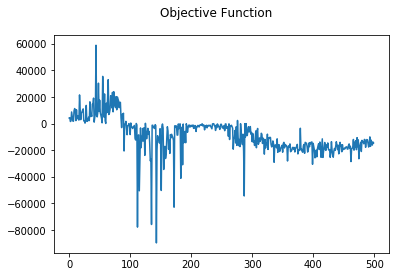

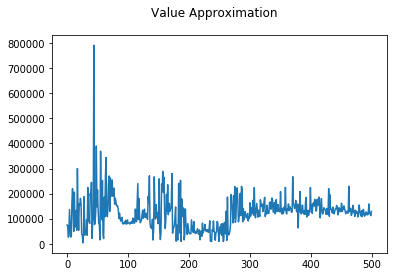

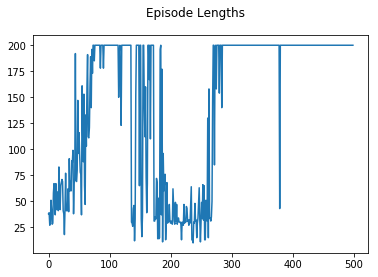

In [13]:
# plot the losses and the avg episode lengths
plt.figure().suptitle("Objective Function")
plt.plot(losses)

plt.figure().suptitle("Value Approximation")
plt.plot(v_losses)

plt.figure().suptitle("Episode Lengths")
plt.plot(avg_episode_lengths)

run the following cell multiple times to see how the trained network performs

In [18]:
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [19]:
play_one_cart_pole_episode(model, env, render=True);

### Check to see how long the cart can balance the pole. 
The following cell ignores the open-ai gym's time-step limit for 200 steps and overrides it to 400. Note that the override only works while testing the network and not while training it. Although the network was trained for 200 timesteps only, it can be seen that the network is able to balance more than that

Feel free to change the max_steps to even higher values

In [24]:
play_one_cart_pole_episode(model, env, render=True, ignore_done=True, max_steps=400);

In [25]:
env.close()

# I hope the notebook helped :) ...